# <font color='firebrick'><center>Exon Validation Report</center></font>
### This report details the results of running the cgat bam_vs_gtf script. The metrics are to look at the number of mapped and spliced reads per bam file.
<br>



,Total reads,Mapped reads,Spliced reads,Unspliced reads,Unmapped reads
X_5Aza_24h_1.hisat,29419506,28441620,7748954,20692666,977886


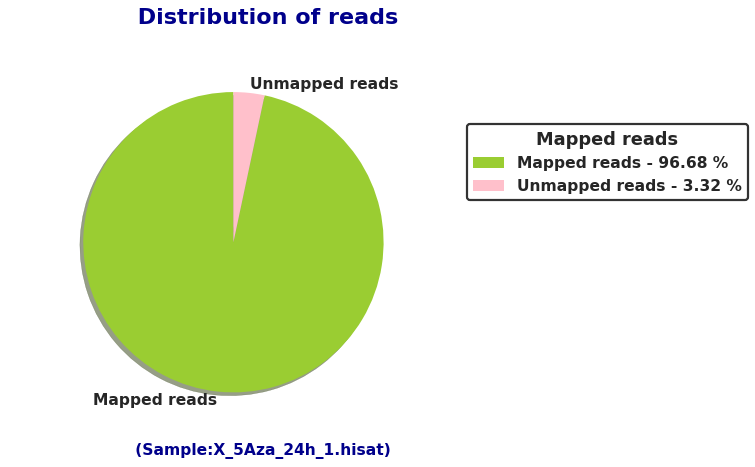

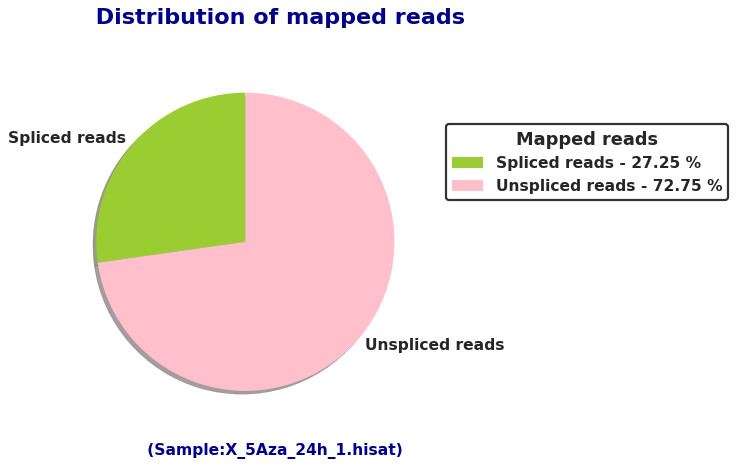

,spliced,spliced_bothoverlap,spliced_exact,spliced_ignored,spliced_inexact,spliced_underrun,others
X_5Aza_24h_1.hisat,7748954,6345094,8537146,1118177,4181096,4163929,302850


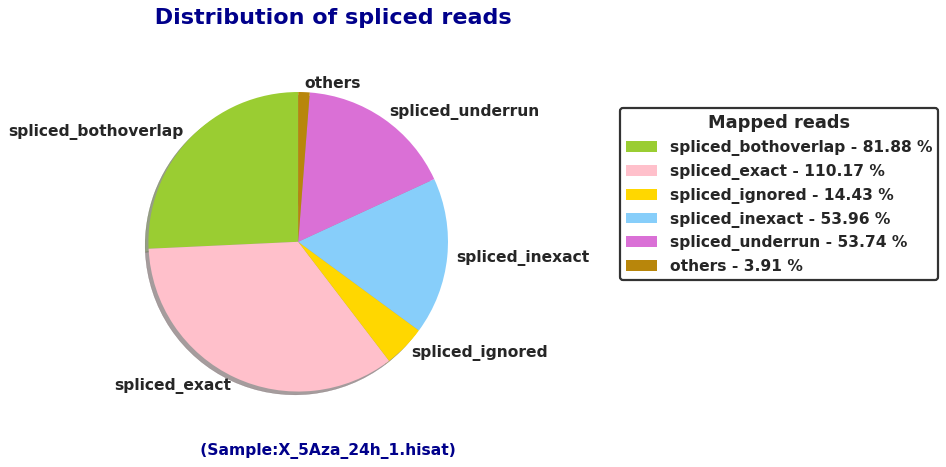

,unspliced,unspliced_nooverlap,unspliced_nooverrun,unspliced_overlap,others
X_5Aza_24h_1.hisat,20692666,4872328,15611095,15820338,209243


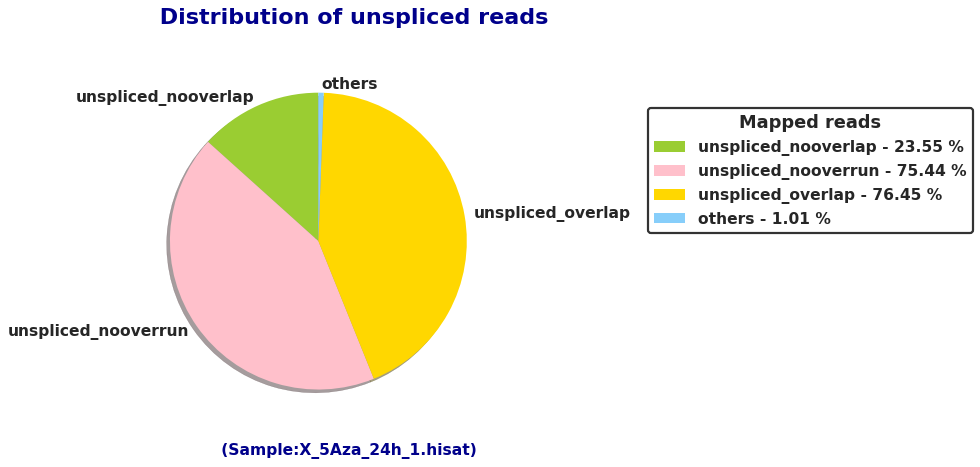

,Total reads,Mapped reads,Spliced reads,Unspliced reads,Unmapped reads
X_5Aza_24h_1_L001.hisat,7437667,7200029,1962447,5237582,237638


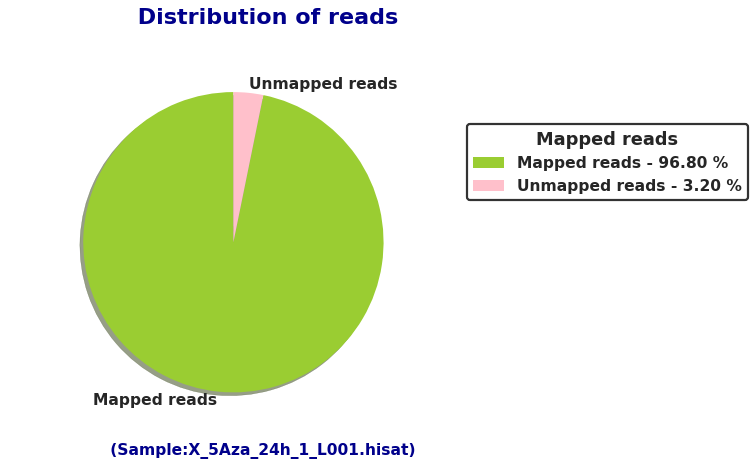

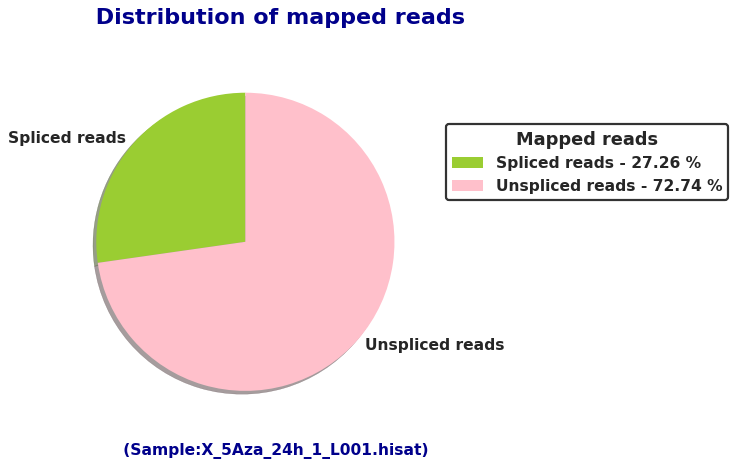

,spliced,spliced_bothoverlap,spliced_exact,spliced_ignored,spliced_inexact,spliced_underrun,others
X_5Aza_24h_1_L001.hisat,1962447,1607421,2164841,281411,1057067,1052745,77937


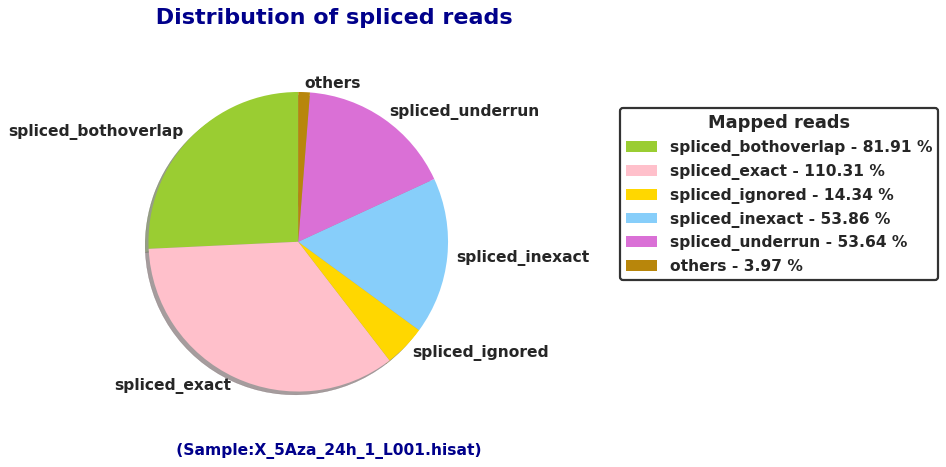

,unspliced,unspliced_nooverlap,unspliced_nooverrun,unspliced_overlap,others
X_5Aza_24h_1_L001.hisat,5237582,1236497,3948061,4001085,53024


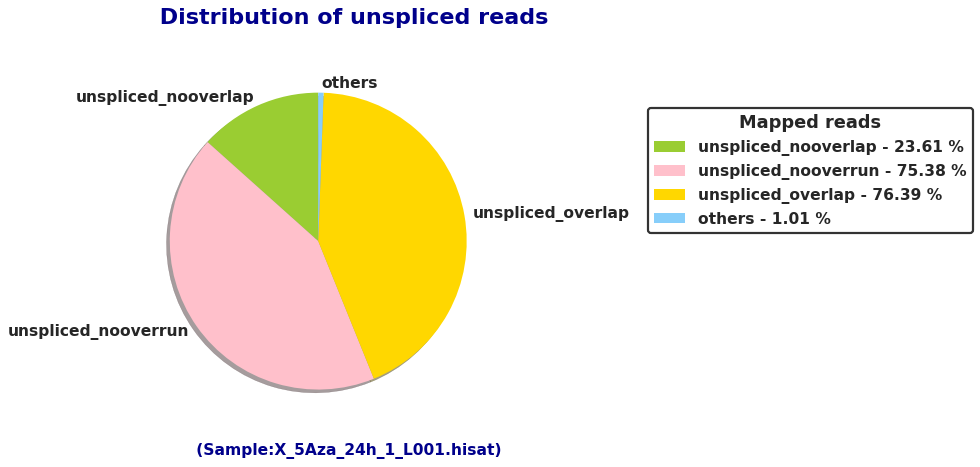

,Total reads,Mapped reads,Spliced reads,Unspliced reads,Unmapped reads
X_5Aza_24h_1_L002.hisat,7552317,7307000,1991928,5315072,245317


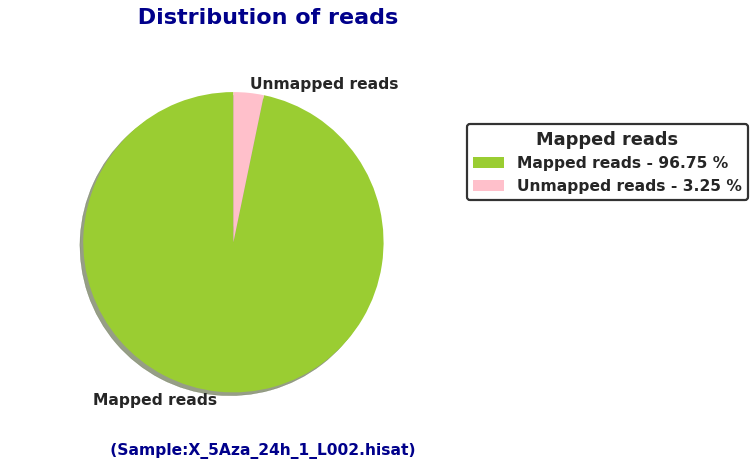

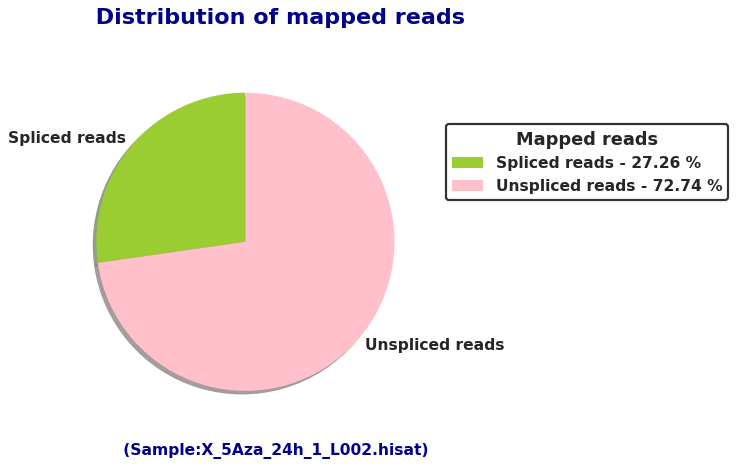

,spliced,spliced_bothoverlap,spliced_exact,spliced_ignored,spliced_inexact,spliced_underrun,others
X_5Aza_24h_1_L002.hisat,1991928,1632032,2194764,287508,1076602,1072158,76832


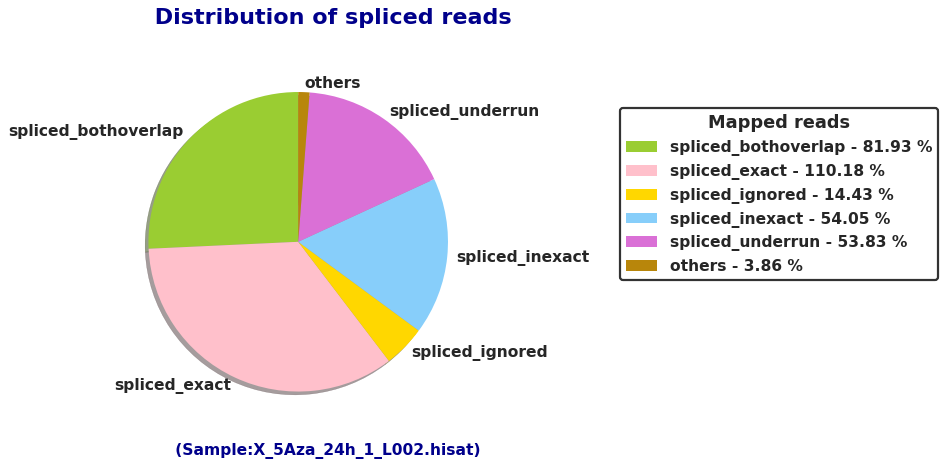

,unspliced,unspliced_nooverlap,unspliced_nooverrun,unspliced_overlap,others
X_5Aza_24h_1_L002.hisat,5315072,1248128,4013172,4066944,53772


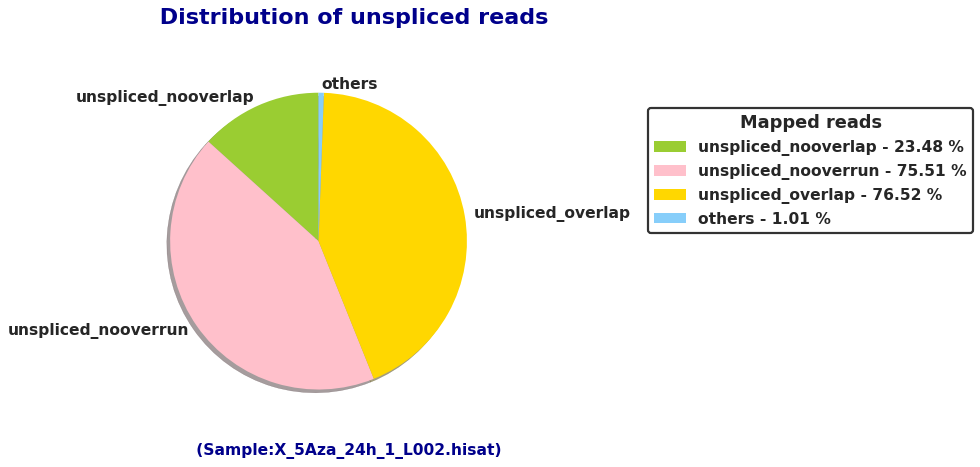

In [9]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di
import csv
import numpy as np
import zlib
import CGAT.IOTools as IOTools
import itertools as ITL
import os
import string
import pandas as pd
import sqlite3
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages  # noqa: E402
#mpl.use('Agg')  # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import rc, font_manager
import CGAT.Experiment as E
import math
from random import shuffle
import matplotlib as mpl
import datetime
import seaborn as sns
import nbformat
%matplotlib inline  


##################################################
#Plot customization
#plt.ioff()
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
title_font = {'size':'20','color':'darkblue', 'weight':'bold', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'18', 'weight':'bold'}
#For summary page pdf
'''To add description page
plt.figure() 
plt.axis('off')
plt.text(0.5,0.5,"my title",ha='center',va='center')
pdf.savefig()
'''
#Panda data frame cutomization
pd.options.display.width = 80
pd.set_option('display.max_colwidth', -1)

feature = ['input','mapped','spliced','unspliced','unmapped']
colors_category = ['yellowgreen', 'pink', 'gold', 'lightskyblue', 
              'orchid','darkgoldenrod','skyblue','b', 'red', 
              'darkorange','grey','violet','magenta','cyan',
              'hotpink','mediumslateblue']
threshold = 5

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

def getTables(dbname):
    '''
    Retrieves the names of all tables in the database.
    Groups tables into dictionaries by annotation
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT name FROM sqlite_master WHERE type='table'"
    c.execute(statement)
    tables = c.fetchall()
    print(tables)
    c.close()
    dbh.close()
    return 

def readDBTable(dbname, tablename):
    '''
    Reads the specified table from the specified database.
    Returns a list of tuples representing each row
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT * FROM %s" % tablename
    c.execute(statement)
    allresults = c.fetchall()
    c.close()
    dbh.close()
    return allresults

def getDBColumnNames(dbname, tablename):
    dbh = sqlite3.connect(dbname)
    res = pd.read_sql('SELECT * FROM %s' % tablename, dbh)
    dbh.close()
    return res.columns


def fancyPiePlot(list_to_plot,list_label,samplename,name,name2,colors,s1,s2):

    fig=plt.figure(figsize=(6, 6), dpi=80)
    patches, autotexts = plt.pie(list_to_plot, colors=colors,labels=list_label,labeldistance=1.06,
                                 autopct=None,shadow=True, startangle=90,textprops={'weight': 'bold','fontsize':'16'})
    for i in range(0,len(autotexts)):
            autotexts[i].set_fontsize(14)
    #texts.set_fontsize(14)
    #for i, a in enumerate(autotexts):
       # a.set_text("{}".format((str(round(list_to_plot[i],2))+"%")))
    plt.axis('equal')
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(list_label, list_to_plot)]
    legend_properties = {'weight':'bold','size':'14'}
    leg = plt.legend(patches,labels,title="Mapped reads",
                     prop=legend_properties,bbox_to_anchor=(s1,s2),frameon=True)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(2)
    leg.get_title().set_fontsize(16)
    leg.get_title().set_fontweight('bold')
    plt.title(''.join(["         Distribution of ",name,"\n\n"]), **title_font)
    plt.xlabel(''.join(["\n\n           (Sample:",samplename,")"]),size=14,color='darkblue',weight='bold')
    plt.tight_layout()
    #plt.savefig(''.join([samplename,'_',name2,'.png']),bbox_inches='tight',pad_inches=0.6)
    plt.show()
    plt.close()
    print("\n\n")
    return fig 


def displayTable(newdf,name):
    # Display table
    styles = [
    hover(),
    dict(selector="th", props=[("font-size", "130%"),
                               ("text-align", "center"),
                              ]),                               
    dict(selector="td", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ]),
    dict(selector="caption", props=[("caption-side", "top"),
                                   ("text-align", "center"),
                                   ("font-size", "100%")])
    ]
    df1 = (newdf.style.set_table_styles(styles).set_caption(name))
    display(df1)
    print("\n")
    
def readSplicedReads(df,index,pdf):
    list_to_plot=[]
    list_label=[]
    list_label_table=[]
    total_count = df['spliced'][index]
    other_category=0
    for i in df.columns:
        line = i
        if(line.find("spliced") > -1):
            if(line == "spliced"):
                list_label_table.append(line)
                continue
            if("unspliced" not in line):
                temp = (df[line][index]*100)/total_count
                if(temp<threshold):
                    other_category = other_category + df[line][index]
                else:
                    list_to_plot.append(df[line][index])
                    list_label.append(line)
                    list_label_table.append(line)
    list_to_plot.append(other_category)
    list_label.append("others")
    table_for_spliced = df[list_label_table].iloc[index].to_frame().T
    table_for_spliced['others'] = pd.DataFrame([other_category], index = table_for_spliced.index)
    table_for_spliced.index = [df['track'][index]]
    del table_for_spliced.index.name
    displayTable(table_for_spliced,"Spliced Reads")
    
    for i in range(0,len(list_to_plot)):
        list_to_plot[i] = (list_to_plot[i]*100)/total_count
                                    
    fig = fancyPiePlot(list_to_plot,list_label,df['track'][index],"spliced reads","spliced_reads",colors_category,
                       1.29, 0.94)
    #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    return pdf


def readUnsplicedReads(df,index,pdf):
    list_to_plot=[]
    list_label=[]
    list_label_table=[]
    total_count = df['unspliced'][index]
    other_category=0
    for i in df.columns:
        line = i
        if(line.find("unspliced") > -1):
                if(line == "unspliced"):
                    list_label_table.append(line)
                    continue
                temp = (df[line][index]*100)/total_count
                if(temp<threshold):
                    other_category = other_category + df[line][index]
                else:
                    list_to_plot.append(df[line][index])
                    list_label.append(line)
                    list_label_table.append(line)
    list_to_plot.append(other_category)
    list_label.append("others")
    table_for_unspliced = df[list_label_table].iloc[index].to_frame().T
    table_for_unspliced['others'] = pd.DataFrame([other_category], index = table_for_unspliced.index)
    table_for_unspliced.index = [df['track'][index]]
    del table_for_unspliced.index.name
    displayTable(table_for_unspliced,"Unspliced Reads")
    
    for i in range(0,len(list_to_plot)):
        list_to_plot[i] = (list_to_plot[i]*100)/total_count
                                    
    fig = fancyPiePlot(list_to_plot,list_label,df['track'][index],"unspliced reads","unspliced_reads",colors_category,
                       1.38, 0.94)
    #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    return pdf

def fragmentLibraryStatsReport(dbname, tablename):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df = trans
    newdf=df[feature]
    newdf.columns = ['Total reads','Mapped reads','Spliced reads','Unspliced reads','Unmapped reads']
    newdf.index = [df['track']]
    #del newdf.index.name
    
    for i in range(0,df.shape[0]):
        #pdf=PdfPages(str("_".join([df['track'][i],"exon_validation_stat_summary.pdf"])))
        print("\n\n\n")
        displayTable(newdf.iloc[i].to_frame().T,"Exon validation Metrices")
        list_to_plot=[]
        list_to_plot.append((newdf.iloc[i][1]*100)/newdf.iloc[i][0])
        list_to_plot.append((newdf.iloc[i][4]*100)/newdf.iloc[i][0])
        fig = fancyPiePlot(list_to_plot,[newdf.columns[1],newdf.columns[4]],df['track'][i],
                           "reads","reads_alignment_stats",colors_category,1.0, 0.89)
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        list_to_plot=[]
        list_to_plot.append((newdf.iloc[i][2]*100)/newdf.iloc[i][1])
        list_to_plot.append((newdf.iloc[i][3]*100)/newdf.iloc[i][1])
        fig = fancyPiePlot(list_to_plot,newdf.columns[2:4],df['track'][i],
                           "mapped reads","mapped_reads_exon_stats",colors_category,1.0, 0.89)
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
        readSplicedReads(df,i,pdf)
        readUnsplicedReads(df,i,pdf)
        #pdf.close()
#getTables("csvdb")
fragmentLibraryStatsReport("../csvdb","exon_validation")




